 # If using Colab

In [0]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/ISY5004')
print(os.getcwd())


In [0]:
!ls

In [3]:
!nvidia-smi

Fri Nov  1 03:41:47 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    86W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

 # Configuration

In [0]:
%tensorflow_version 1.x
import math
baseModelName = "FRCNN"
base_net_type = 'vgg'   # either 'vgg' or 'resnet50'
modelName = baseModelName + "_" + base_net_type
model_path = modelName + ".hdf5"
csv_path = modelName + ".csv"

num_epochs = 40

im_size = 300                       # shorter-side length. Original is 600, half it to save training time
anchor_box_scales = [64,128,256]    # also half box_scales accordingly. Original is [128,256,512]
anchor_box_ratios = [[1,1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]] # anchor box ratios area == 1
num_rois = 256


 # Load data

In [0]:
parseAnnotation = False

# Parsing of data especially through Google Colab is slow, so we should save the results so that we do it once only
import pickle
annotation_train_path = './data/annotation_train.txt'

if parseAnnotation:
  from FRCNN import parseAnnotationFile
  classes_of_interest = ['bicycle', 'bus', 'car', 'motorbike', 'person']
  train_data, classes_count, class_mapping = parseAnnotationFile(annotation_train_path, mode='simple', filteredList=classes_of_interest)

  with open('./data/all_data.pickle', 'wb') as f2:
      pickle.dump((train_data, classes_count, class_mapping), f2)

else:
  # Load from pickle
  with open('./data/all_data.pickle', 'rb') as f_in:
      train_data, classes_count, class_mapping = pickle.load(f_in)
  
  for i in range(len(train_data)):
    train_data[i]['filepath'] = train_data[i]['filepath'].replace('\\', '/')

 ## Inspect annotation file with a sample image

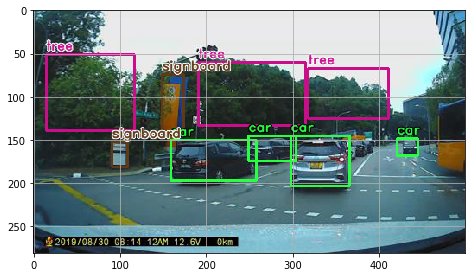

In [4]:
from FRCNN import viewAnnotatedImage
viewAnnotatedImage('./data/annotation_train.txt', 'data/train/image1095.jpg')

 # Create and Train FRCNN model

 ## Create

In [5]:
from FRCNN import FRCNN
num_anchors = len(anchor_box_scales) * len(anchor_box_ratios)
frcnn = FRCNN(input_shape=(None,None,3), num_anchors=num_anchors, num_rois=num_rois, base_net_type=base_net_type, num_classes = len(classes_count))
frcnn.compile()


58892288/58889256 [==============================] - 1s 0us/step


 ## Visualise

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1a (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1a (Conv2D)          (None, None, None, 6 1792        input_1a[0][0]                   
__________________________________________________________________________________________________
block1_conv2a (Conv2D)          (None, None, None, 6 36928       block1_conv1a[0][0]              
__________________________________________________________________________________________________
block1_poola (MaxPooling2D)     (None, None, None, 6 0           block1_conv2a[0][0]              
______________________________________________________________________________________________

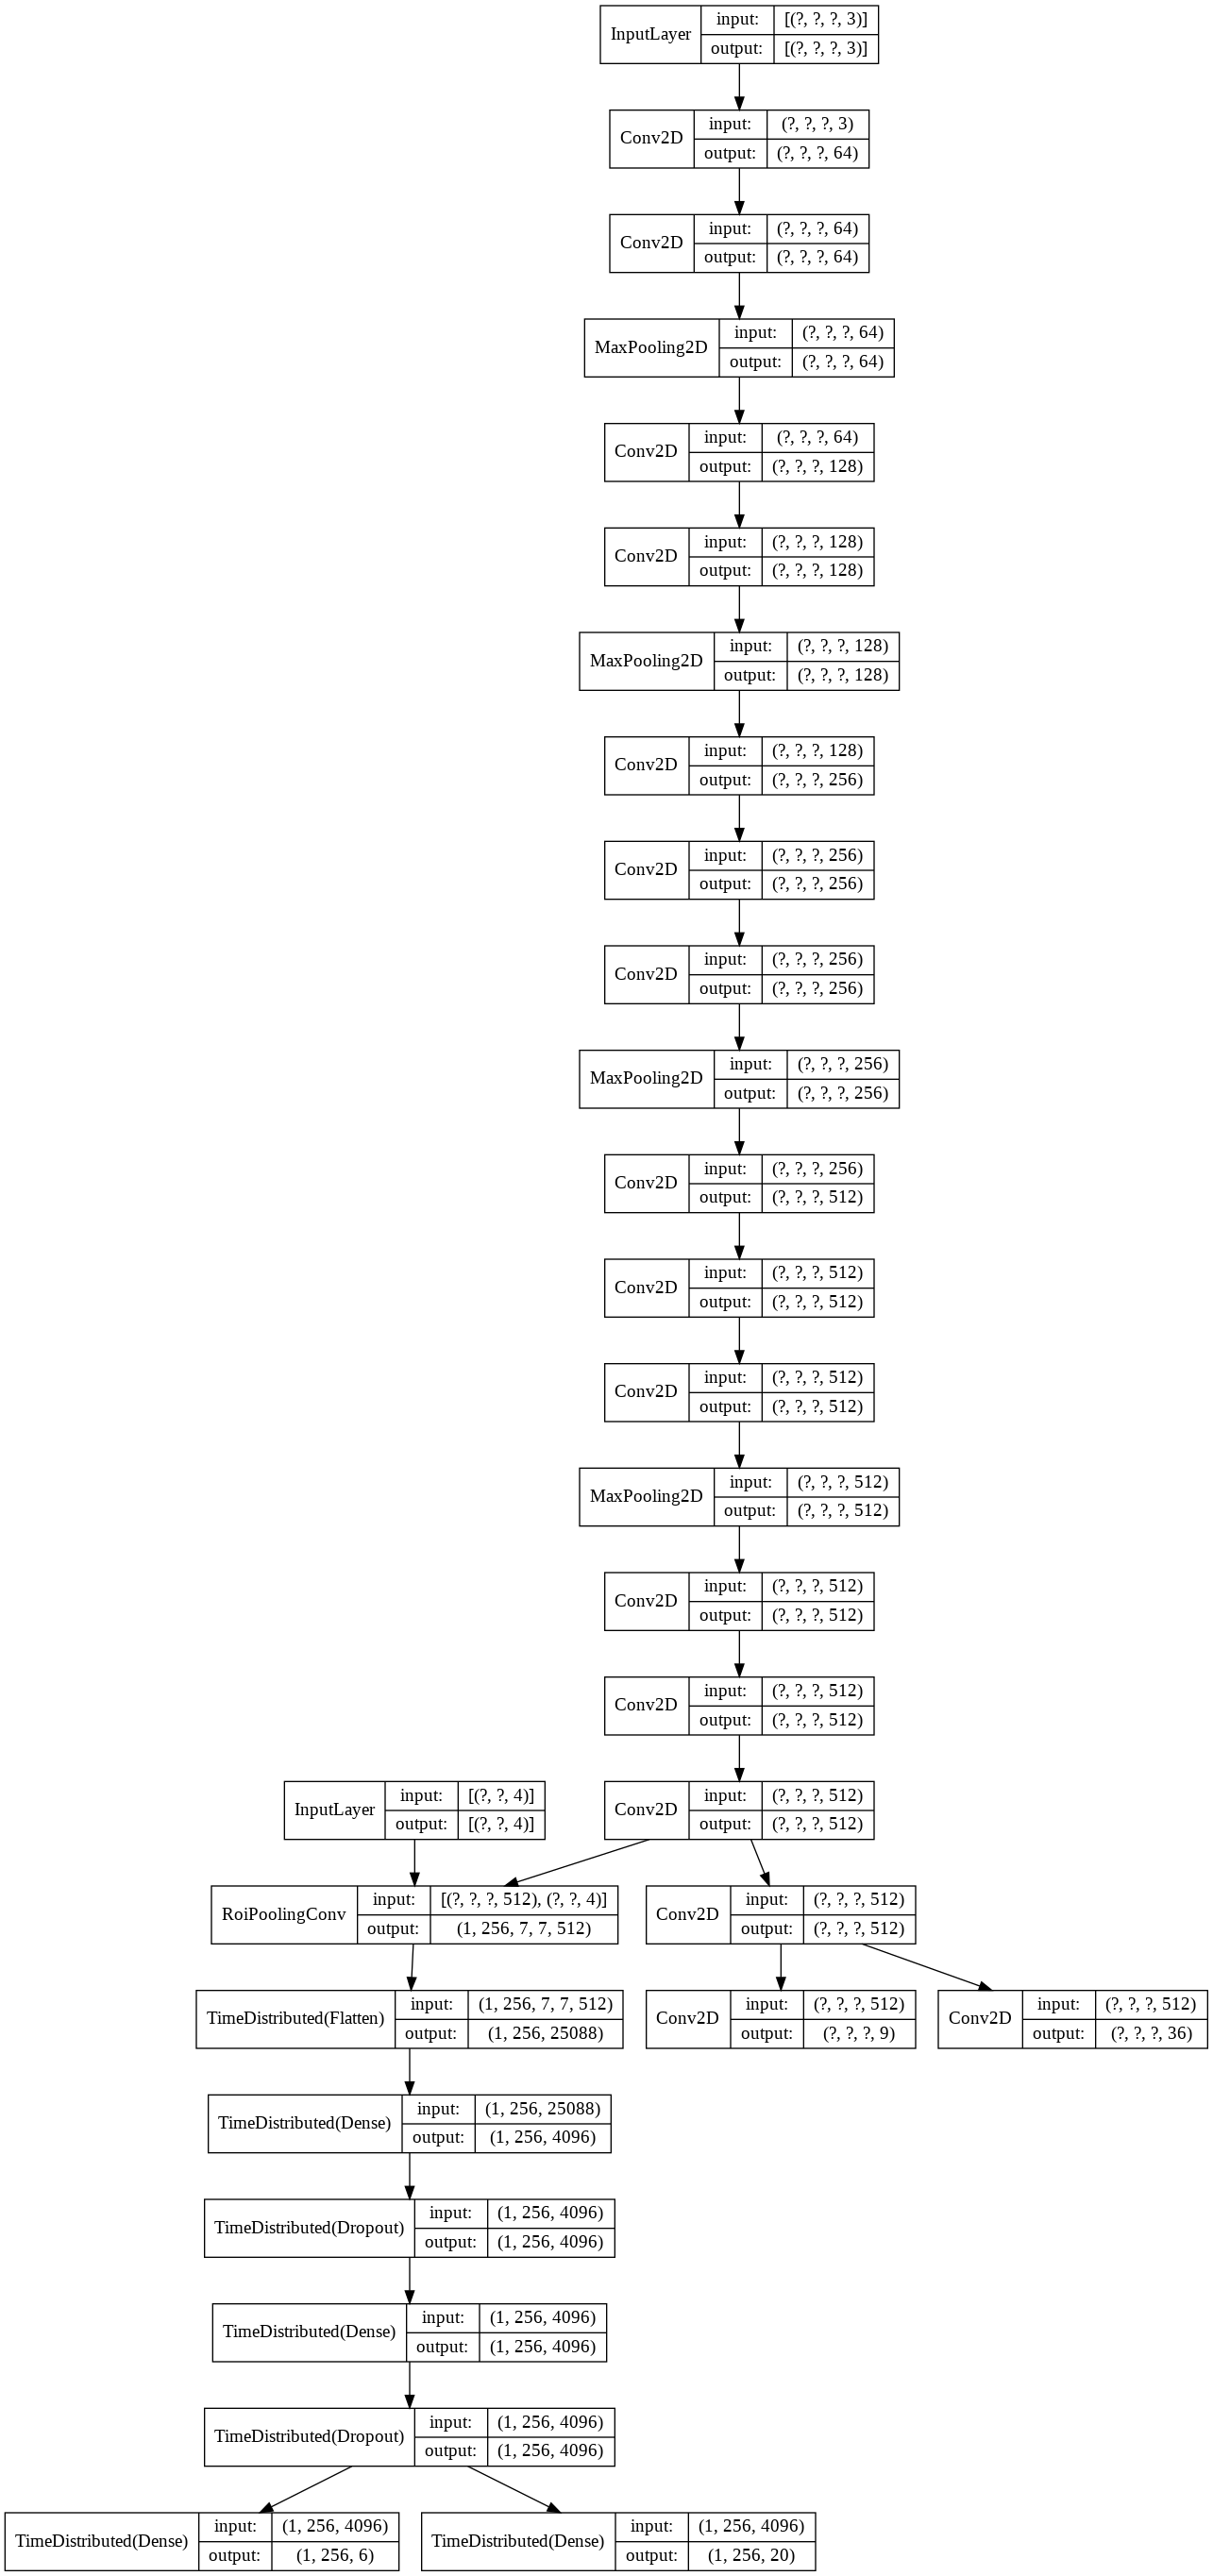

In [6]:
frcnn.model_rpn.summary()
#frcnn.summary()

# Plot structure of FRCNN
from tensorflow.keras.utils import plot_model
plot_model(frcnn.model_all, to_file=modelName+'.png', show_shapes=True, show_layer_names=False, rankdir='TB')


 ## Train

Original image: height=281 width=500
Resized image:  height=300 width=533 im_size=300
Feature map size: height=18 width=33 rpn_stride=16
(1, 300, 533, 3)
2 includes 'y_rpn_cls' and 'y_rpn_regr'
Shape of y_rpn_cls (1, 18, 33, 18)
Shape of y_rpn_regr (1, 18, 33, 72)
{'filepath': 'data/train/image1029.jpg', 'width': 500, 'height': 281, 'bboxes': [{'class': 'person', 'x1': 358, 'x2': 371, 'y1': 150, 'y2': 187}, {'class': 'person', 'x1': 336, 'x2': 342, 'y1': 156, 'y2': 189}, {'class': 'person', 'x1': 314, 'x2': 327, 'y1': 156, 'y2': 191}, {'class': 'motorbike', 'x1': 218, 'x2': 259, 'y1': 160, 'y2': 188}, {'class': 'car', 'x1': 186, 'x2': 204, 'y1': 164, 'y2': 176}, {'class': 'car', 'x1': 139, 'x2': 161, 'y1': 164, 'y2': 180}, {'class': 'car', 'x1': 436, 'x2': 477, 'y1': 155, 'y2': 177}, {'class': 'person', 'x1': 376, 'x2': 385, 'y1': 146, 'y2': 187}]}
Number of positive anchors for this image: 8
(array([ 4,  5,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 11, 11, 12, 12,
       12, 12, 13,

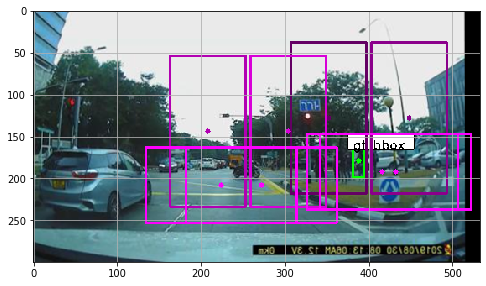

In [7]:
## create iterator
from FRCNN import FRCNNGenerator, inspect, preprocess_input
train_it = FRCNNGenerator(train_data,
    target_size=im_size,
    horizontal_flip=True, vertical_flip=False, rotation_range=5, 
    width_shift_range=0.2,
    shuffle=True, base_net_type=base_net_type,
    preprocessing_function=preprocess_input
)

inspect(train_it, im_size)


In [0]:
# train model - initial_epoch = -1 --> will automatically resume training if csv and model already exists
steps = 1000
frcnn.fit_generator(train_it, target_size = im_size, class_mapping = class_mapping, epochs=num_epochs, steps_per_epoch=steps,
    model_path=model_path, csv_path=csv_path, initial_epoch=-1)


 # Examine Performance

 # Test FRCNN model

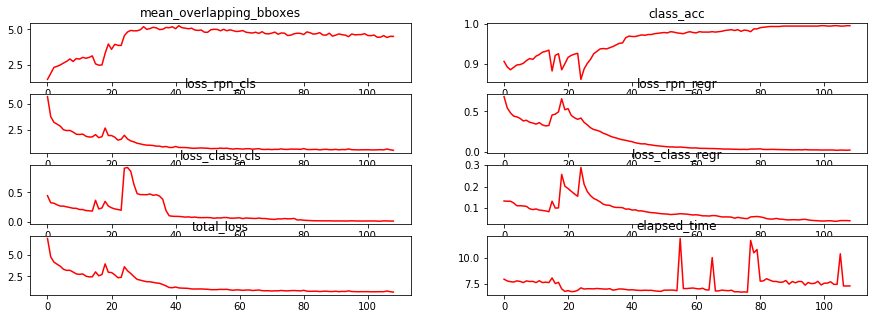

In [8]:
# Load records of training, and view the accuracy and loss
from FRCNN import plotAccAndLoss
plotAccAndLoss('FRCNN_vgg.csv')

In [9]:
import math
parseAnnotation = False

# Parsing of data especially through Google Colab is slow, so we should save the results so that we do it once only
baseModelName = "FRCNN"
base_net_type = 'vgg'   # either 'vgg' or 'resnet50'
modelName = baseModelName + "_" + base_net_type
model_path = modelName + ".hdf5"

im_size = 300                       # shorter-side length. Original is 600, half it to save training time
anchor_box_scales = [64,128,256]    # also half box_scales accordingly. Original is [128,256,512]
anchor_box_ratios = [[1,1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]] # anchor box ratios area == 1
num_rois = 256
num_anchors = len(anchor_box_scales) * len(anchor_box_ratios)


import pickle
if parseAnnotation:
  # Load image information
  from FRCNN import parseAnnotationFile
  annotation_train_path = './data/annotation_train.txt'
  classes_of_interest = ['bicycle', 'bus', 'car', 'motorbike', 'person']
  train_data, classes_count, class_mapping = parseAnnotationFile(annotation_train_path, mode='simple', filteredList=classes_of_interest)

  annotation_test_path = './data/annotation_test.txt'
  test_data, _ , _ = parseAnnotationFile(annotation_test_path, mode='simple', filteredList=classes_of_interest)

  with open('./data/all_data.pickle', 'wb') as f2:
      pickle.dump((train_data, classes_count, class_mapping), f2)
  with open('./data/test_data.pickle', 'wb') as f2:
      pickle.dump(test_data, f2)

else:
  # Load from pickle
  with open('./data/all_data.pickle', 'rb') as f_in:
      train_data, classes_count, class_mapping = pickle.load(f_in)
  
  for i in range(len(train_data)):
    train_data[i]['filepath'] = train_data[i]['filepath'].replace('\\', '/')

  with open('./data/test_data.pickle', 'rb') as f_in:
      test_data = pickle.load(f_in)


# Create model and load trained weights (Note: class mapping and num_classes should be based on training set)
from FRCNN import FRCNN
frcnn_test = FRCNN(input_shape=(None,None,3), num_anchors=num_anchors, num_rois=num_rois, base_net_type=base_net_type, num_classes = len(classes_count))
frcnn_test.load_config(anchor_box_scales=anchor_box_scales, anchor_box_ratios=anchor_box_ratios, num_rois=num_rois, target_size=im_size)
frcnn_test.load_weights(model_path)
frcnn_test.compile()

# Load array of images
from FRCNN import convertDataToImg
test_imgs = convertDataToImg(test_data)


Retrieving images from filepaths
93/93 [==============================] - 35s 371ms/step



In [10]:
# Perform predictions
# predicts = frcnn_test.predict(test_data, class_mapping=class_mapping, verbose=2, bbox_threshold=0.5, overlap_thres=0.2)
predicts = frcnn_test.predict(test_imgs, class_mapping=class_mapping, verbose=2, bbox_threshold=0.5, overlap_thres=0.2)

Output hidden; open in https://colab.research.google.com to view.

In [11]:
import numpy as np
evaluate = frcnn_test.evaluate(test_data, class_mapping=class_mapping, verbose=2)

Output hidden; open in https://colab.research.google.com to view.